# Quick Overview

This notebook provides a quick example of how to start using the `spectral_recovery` package. More detailed examples will soon become available in the [User Guide](https://people-er.github.io/Spectral-Recovery/about/).

If you want to try out the tool on your own, you can use the [test data on GitHub](https://github.com/PEOPLE-ER/Spectral-Recovery/tree/main/docs/test_data/test_data.zip).

Once the tool is installed with `pip install spectral-recovery`, you can import the package

In [3]:
import spectral_recovery as sr

## Defining a RestorationArea

To begin, we must create a `RestorationArea` object. This object holds and coordinates all the information necessary to compute recovery metrics for an area that has experienced disturbance and/or restoration. The following section briefly describes the input parameters but for more in-depth information, please see the [Spectral Recovery Tool](https://people-er.github.io/Spectral-Recovery/about/#2-the-spectral-recovery-tool) section in the User Guide.

### Input Parameters

| Name  | Type  | Description  |
|---|:---:|---|
| **restoration_polygon**  | geopandas.GeoDataFrame  | The spatial deliniation of the restoration event, i.e where disturance/restoration has occured.  |   
|  **restoration_start** | datetime | The start year of the restoration window.  |   
| **disturbance_start**  | datetime  |  The start year of the disturbance window. |  
|  **reference_polygon** | geopandas.GeoDataFrame  | The spatial deliniation of the reference systems.  |   
|  **reference_years** | list of datetime  | The year or range of years to use for determining a recovery target.  |   
|  **composite_stack** | xarray.DataArray  | The timeseries of annual composites for computing recovery metrics.   |  

### Prepping Inputs

#### Annual Composites

Next, read in your set of annual composites. To do this use the `read_and_stack_tifs` method. The method requires that you either provide a path to a directory containing all of your annual composites, or you provide a list of paths to each individual composite. Each composite:

1. _must_ be named after the year of which they are a composite, e.g for a composite of 2014 the file must be named `2014.tif`
2. _must_ have the bands named by their common names/acronyms

Each composite can contain multiple bands but each band must be present in all composites. You must also provide the Platform(s) from which the composite is derived.

| Parameter   | Options   |
|:---:|---|
|  Platform   | 'landsat_oli', 'landsat_etm', 'landsat_tm','sentinel_2' |

The set of annual composites that we'll be using in this notebook was created using the [GEE BAP tool](https://github.com/saveriofrancini/bap).

In [4]:
composite_stack = sr.read_and_stack_tifs(
    "test_data/annual_composites/landsat",
    platform=["landsat_tm", "landsat_etm", "landsat_oli"],
    band_names={1: "blue", 2: "green", 3: "red", 4: "nir", 5: "swir1", 6: "swir2"},
    array_type="numpy"
)
composite_stack

<xarray.DataArray (band: 6, time: 24, y: 97, x: 118)>
array([[[[0.0116, 0.0116, 0.0116, ..., 0.0114, 0.0114, 0.0114],
         [0.0116, 0.0116, 0.0116, ..., 0.0114, 0.0114, 0.0114],
         [0.0116, 0.0116, 0.0116, ..., 0.0114, 0.0114, 0.0114],
         ...,
         [0.0155, 0.0117, 0.0117, ..., 0.0173, 0.0173, 0.0173],
         [0.0155, 0.0117, 0.0117, ..., 0.0173, 0.0173, 0.0173],
         [0.0155, 0.0154, 0.0154, ..., 0.0097, 0.0097, 0.0097]],

        [[0.0129, 0.017 , 0.017 , ..., 0.    , 0.    , 0.    ],
         [0.0129, 0.017 , 0.017 , ..., 0.    , 0.    , 0.    ],
         [0.0129, 0.017 , 0.017 , ..., 0.    , 0.    , 0.    ],
         ...,
         [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
         [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
         [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],

        [[0.0146, 0.0166, 0.0166, ..., 0.0131, 0.0131, 0.0131],
         [0.0146, 0.0166, 0.0166, ..., 0.0131, 0.0131, 0.0131],
         [0.0146, 0.0166, 0.0166, ..., 0.0131, 0.0131, 0.0131],
         ...,
...
         [0.0462, 0.0508, 0.0508, ..., 0.0495, 0.0495, 0.0495],
         [0.0462, 0.0508, 0.0508, ..., 0.0495, 0.0495, 0.0495],
         [0.0388, 0.0411, 0.0411, ..., 0.039 , 0.039 , 0.039 ]],

        [[0.0383, 0.0375, 0.0375, ..., 0.0352, 0.0352, 0.0352],
         [0.0383, 0.0375, 0.0375, ..., 0.0352, 0.0352, 0.0352],
         [0.0383, 0.0375, 0.0375, ..., 0.0352, 0.0352, 0.0352],
         ...,
         [0.0486, 0.0538, 0.0538, ..., 0.0566, 0.0566, 0.0566],
         [0.0486, 0.0538, 0.0538, ..., 0.0566, 0.0566, 0.0566],
         [0.041 , 0.0432, 0.0432, ..., 0.0443, 0.0443, 0.0443]],

        [[0.034 , 0.0318, 0.0318, ..., 0.0296, 0.0296, 0.0296],
         [0.034 , 0.0318, 0.0318, ..., 0.0296, 0.0296, 0.0296],
         [0.034 , 0.0318, 0.0318, ..., 0.0296, 0.0296, 0.0296],
         ...,
         [0.044 , 0.0459, 0.0459, ..., 0.0518, 0.0518, 0.0518],
         [0.044 , 0.0459, 0.0459, ..., 0.0518, 0.0518, 0.0518],
         [0.036 , 0.0373, 0.0373, ..., 0.0363, 0.0363, 0.0363]]]],
      dtype=float32)
Coordinates:
  * x            (x) float64 4.922e+05 4.923e+05 ... 4.934e+05 4.934e+05
  * y            (y) float64 5.968e+06 5.968e+06 ... 5.967e+06 5.967e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2023-01-01
  * band         (band) object BLUE GREEN RED NIR SWIR1 SWIR2
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.31940001249313
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('blue', 'green', 'red', 'nir', 'swir1', 'swir2')
    platform:            [<Platform.LANDSAT_TM: 3>, <Platform.LANDSAT_ETM: 2>...

Compute your indices using the `compute_indices` function. The function takes 2 parameters 1) your image stack, 2) choice of indices.

| Parameter   | Options   |
|:---:|---|
|  Indices   | 'NDVI', 'NBR','GNDVI', 'EVI', 'AVI', 'SAVI','NDWI','TCG','TCW','TCB','SR','NDMI','GCI','NDII'  |


In [5]:
indices_stack = sr.compute_indices(
    image_stack=composite_stack, 
    indices=["NBR", "NDMI", "GNDVI"]
)
indices_stack

<xarray.DataArray (band: 3, time: 24, y: 97, x: 118)>
array([[[[0.6535714 , 0.67439467, 0.67439467, ..., 0.7138643 ,
          0.7138643 , 0.7138643 ],
         [0.6535714 , 0.67439467, 0.67439467, ..., 0.7138643 ,
          0.7138643 , 0.7138643 ],
         [0.6535714 , 0.67439467, 0.67439467, ..., 0.7138643 ,
          0.7138643 , 0.7138643 ],
         ...,
         [0.69090915, 0.68697375, 0.68697375, ..., 0.6059794 ,
          0.6059794 , 0.6059794 ],
         [0.69090915, 0.68697375, 0.68697375, ..., 0.6059794 ,
          0.6059794 , 0.6059794 ],
         [0.6775619 , 0.70955884, 0.70955884, ..., 0.65999067,
          0.65999067, 0.65999067]],

        [[0.6158745 , 0.66303027, 0.66303027, ...,        nan,
                 nan,        nan],
         [0.6158745 , 0.66303027, 0.66303027, ...,        nan,
                 nan,        nan],
         [0.6158745 , 0.66303027, 0.66303027, ...,        nan,
                 nan,        nan],
...
         [0.7309205 , 0.69095695, 0.69095695, ..., 0.69989437,
          0.69989437, 0.69989437],
         [0.7309205 , 0.69095695, 0.69095695, ..., 0.69989437,
          0.69989437, 0.69989437],
         [0.75318795, 0.7258839 , 0.7258839 , ..., 0.6914987 ,
          0.6914987 , 0.6914987 ]],

        [[0.72249264, 0.7340425 , 0.7340425 , ..., 0.7380952 ,
          0.7380952 , 0.7380952 ],
         [0.72249264, 0.7340425 , 0.7340425 , ..., 0.7380952 ,
          0.7380952 , 0.7380952 ],
         [0.72249264, 0.7340425 , 0.7340425 , ..., 0.7380952 ,
          0.7380952 , 0.7380952 ],
         ...,
         [0.7223651 , 0.6945858 , 0.6945858 , ..., 0.6853177 ,
          0.6853177 , 0.6853177 ],
         [0.7223651 , 0.6945858 , 0.6945858 , ..., 0.6853177 ,
          0.6853177 , 0.6853177 ],
         [0.73472154, 0.70646757, 0.70646757, ..., 0.68840224,
          0.68840224, 0.68840224]]]], dtype=float32)
Coordinates:
  * x            (x) float64 4.922e+05 4.923e+05 ... 4.934e+05 4.934e+05
  * y            (y) float64 5.968e+06 5.968e+06 ... 5.967e+06 5.967e+06
  * time         (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2023-01-01
    spatial_ref  int32 0
  * band         (band) object NBR NDMI GNDVI

#### Polygons

Read your restoration polygon using GeoPandas

Text(0.5, 1.0, 'Test restoration polygon')

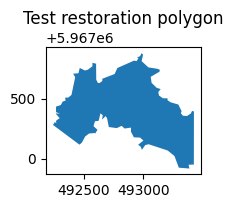

In [6]:
import geopandas as gpd

restoration_poly = gpd.read_file("test_data/wildfire_516.gpkg")
restoration_poly.plot(figsize=(2, 2)).set_title("Test restoration polygon")

#### Dates/Years

Finally, define the years we need for a restoration area: the start year of the disturbance and restoration windows. 

In [7]:
disturbance_start = "2005" # the start of the disturbance window
restoration_start ="2006" # the start of the restoration window

### Creating a RestorationArea

Now that we've prepped our input, we can create a RestorationArea and are one step closer to computing recovery metrics.

A novel feature of the `spectral_recovery` package is that it allows users to choose between using a [historic recovery target](https://people-er.github.io/Spectral-Recovery/about/#14-recovery-targets) or a [reference recovery target](https://people-er.github.io/Spectral-Recovery/about/#14-recovery-targets) when computing recovery metrics. Be sure to consult the user guide and current literature when deciding which type of target works best for computing your recovery metrics.

#### RestorationArea with Historical Recovery Target

A historical recovery target is computed using historic (prior to disturbance) values from the restoration site. Historic recovery targets are computed on a per-pixel basis, meaning that each pixel in the restoration site has a unique recovery target. To create a `RestorationArea` object that uses a historic recovery target, provide the restoration site and set the appopriate reference years. If a list of two reference years are provided then the median between the two years is used as the target.

In [8]:
reference_years = ["2003", "2004"] # two years prior to the disturbance window

ra_hist = sr.RestorationArea(
    restoration_polygon=restoration_poly,
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack,
)

You can visualize the spectral trajectory of your RestorationArea using the `plot_spectral_trajectory` function. If you want to write the plot to file, pass your desired path to the function.

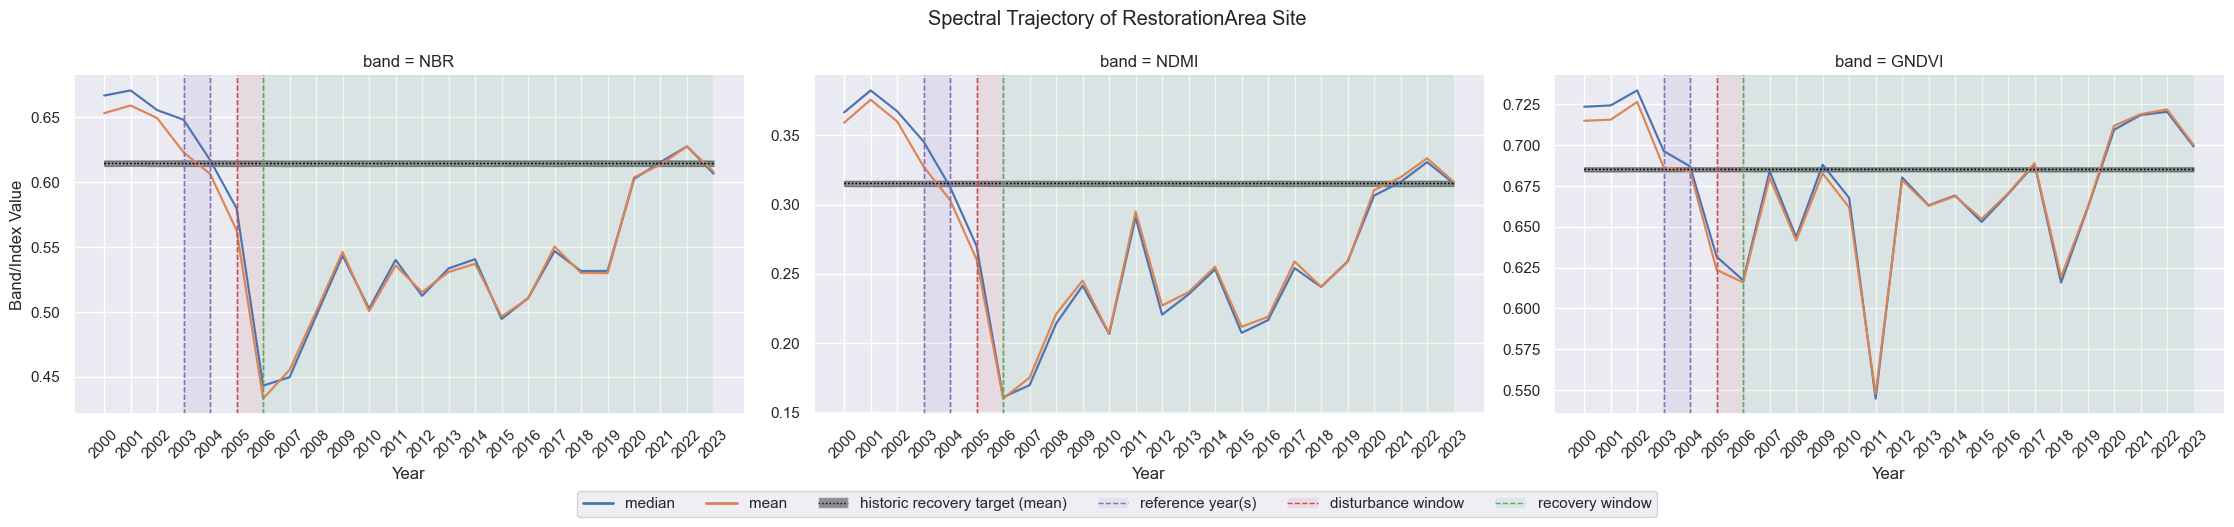

In [9]:
ra_hist.plot_spectral_trajectory()
# or
# ra_hist.plot_spectral_trajectory("path/to/your_plot.png")

#### RestorationArea with Reference Recovery Target

A reference recovery target is computed using an area(s) in the same landscape as the restoration site that exhibits desirable, healthy, and stable ecosystem conditions (Gann et al., 2019). Reference areas can be composed of a single or multiple polygons. If the latter, the median of all individual polygon targets is taken to be the recovery target. All reference targets are a single value (i.e one value per-band), computed as the median across time and then space. To create a `RestorationArea` object that uses a reference recovery target, pass your reference site polygon(s) to the `reference_polygon=` parameter and set the appropriate reference years for your reference area.

In [ ]:
reference_poly = gpd.read_file("path/to/reference.gpkg")
reference_years = ["2022", "2023"] # use the two most recent years as the reference

ra_ref = sr.RestorationArea(
    restoration_polygon=restoration_poly,
    reference_polygon=reference_poly, # set this param to use a reference recovery target
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack, # make sure to use a stack of images that contains the reference polygon, too!
)

## Computing Recovery Metrics

In [67]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from matplotlib.colors import ListedColormap

def plot_metrics(metric, **kwargs):
    """ Plot the three bands in a single figure. """
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
    for i in range(3):
        
        metric[0,i,:,:].plot(ax=axes[i], **kwargs)

        axes[i].set_title(f"{str(metric.metric.values[0])}: {metric['band'].values[i]}")
        axes[i].set_xlabel("X coordinate")
        if i == 0:
            axes[i].set_ylabel("Y coordinate")
        else:
            axes[i].set_ylabel("")
        axes[i].set_
        plt.tight_layout()


Now that we have our RestorationArea defined, computing recovery metrics is as simple as calling the desired metric method!

### Y2R

Years-to-Recovery (Y2R) is a recovery metric the measures length of time (years) for a given pixel to reach 80% of it's recovery target value (Wulder et al., 2019; Frazier et al., 2018, De Keersmaecker et al., 2022). Given a recovery window that is $i$ years long, pixels that have recovered will have value between 0 - $i$, representing the number of years it tookfor the pixel to hit 80% of their recovery target. A value of 0 means that the pixel started at or above the threshold at the start of the recovery window, 1 means it took 1 year to reach the threshold, etc. Pixels that have not reached 80% of the recovery target at any point within the recovery window are given a value of -9999. 

In [72]:
y2r = ra_hist.y2r()

#### Recovered Pixels

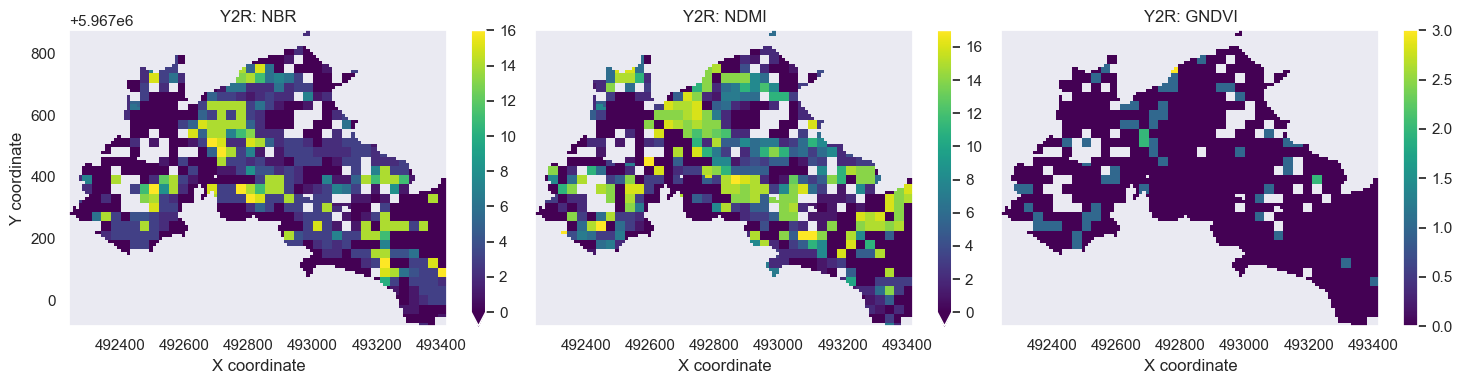

In [73]:
# To simplify visualizations, first only look at pixels values above 0 (i.e., pixels that have recovered)
plot_metrics(y2r, vmin=0)

#### Unrecovered vs. Recovered Pixels

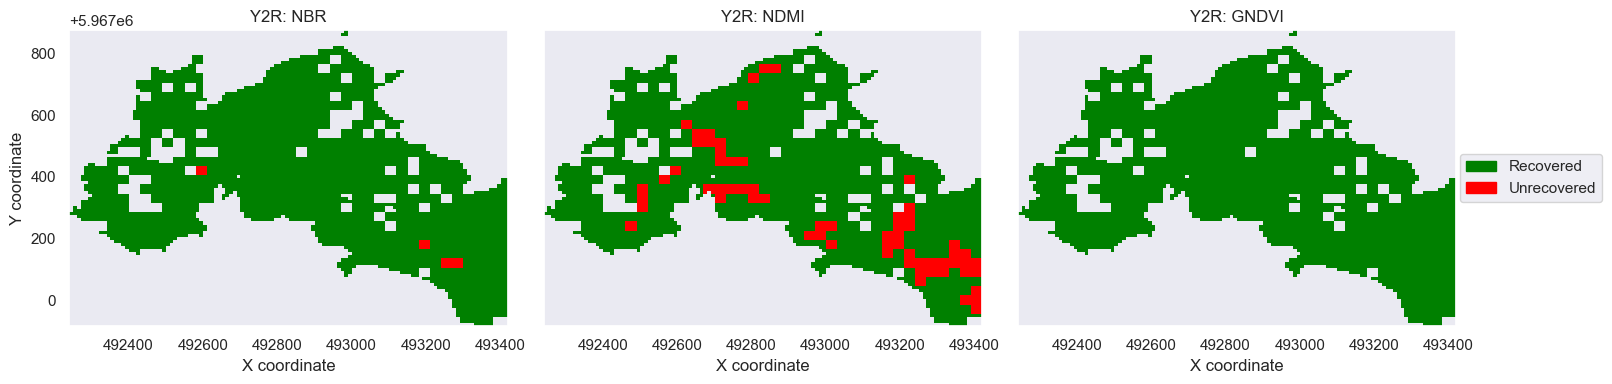

In [86]:
from matplotlib.patches import Patch
# Next, look at pixels that have value -9999 (i.e., pixels that have not recovered)
unrecovered = y2r.where(y2r==-9999, 0)
unrecovered_with_nan = unrecovered.where(~y2r.isnull(), np.nan)

plot_metrics(unrecovered_with_nan, add_colorbar=False, cmap=ListedColormap(["red", "green"]))
# Add a legend for clarity
items = [Patch(facecolor='green', edgecolor='green', label="Recovered"),
                Patch(facecolor='red', edgecolor='red', label="Unrecovered")]
plt.legend(handles=items, loc="center right", bbox_to_anchor=(1.35, 0.5))

### R80P

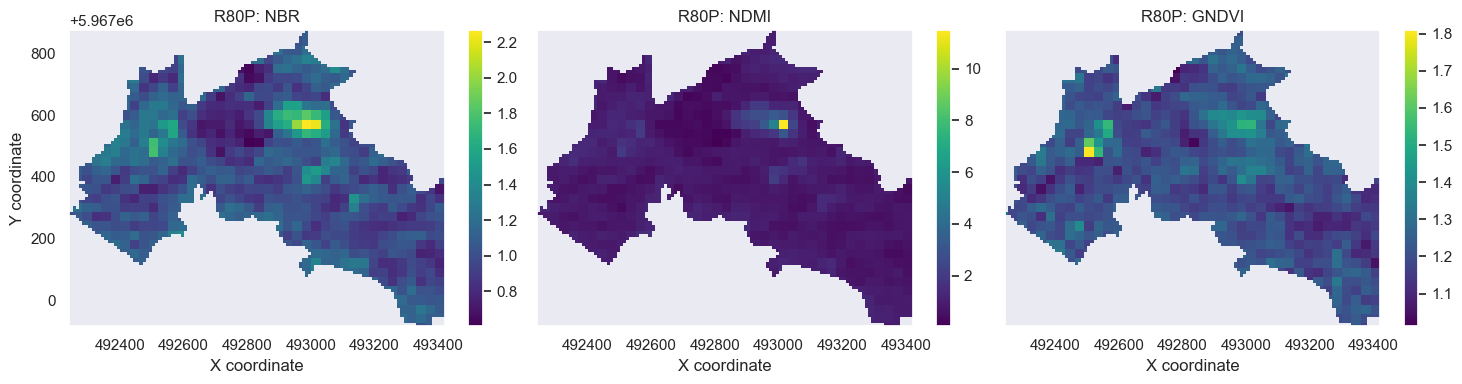

In [11]:
r80p = ra_hist.r80p(timestep=4)
plot_metrics(r80p)

### YrYr

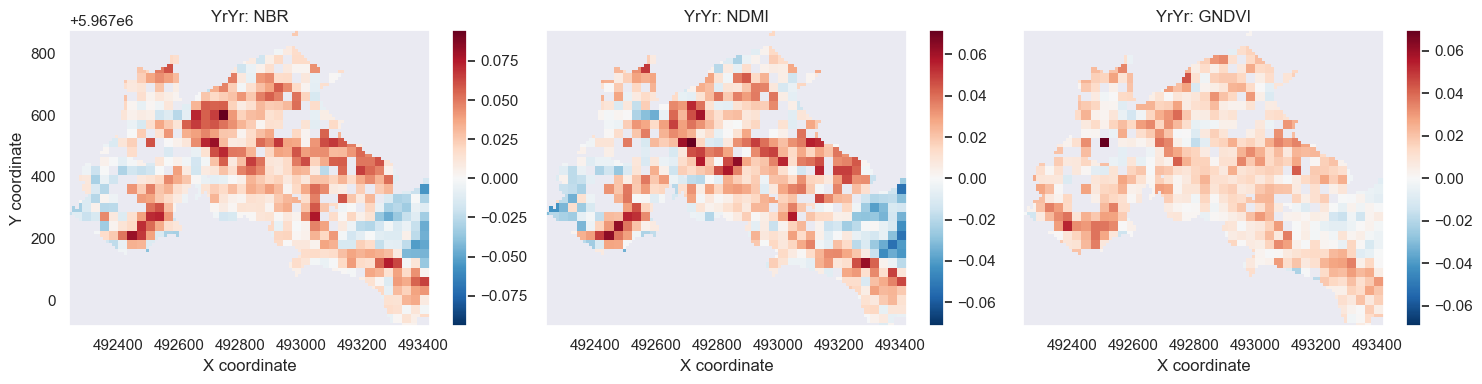

In [12]:
yryr = ra_hist.yryr(timestep=4)
plot_metrics(yryr)

### dNBR

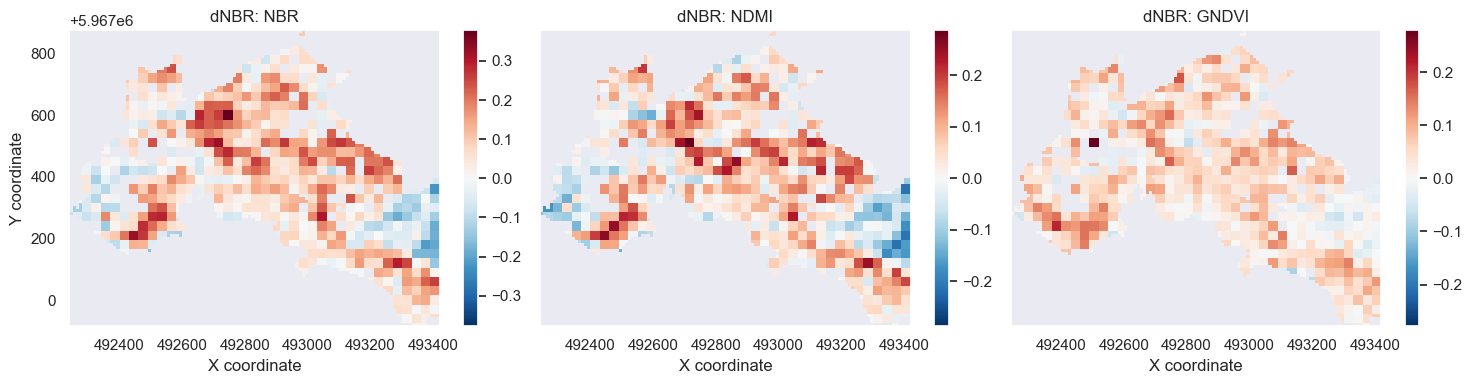

In [13]:
dNBR = ra_hist.dnbr(timestep=4)
plot_metrics(dNBR)

###  Writing Results

To write your metric results to raster files, the simpliest way is to use `rioxarray`'s `to_raster` function:


In [ ]:
y2r[0,:,:,:].rio.to_raster("./y2r.tif")